# Hysteresis Loops Fitting

In [2]:
import sys
sys.path.append('../../')
# sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")
sys.path.append('../../src')

In [3]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-06-22 05:32:59.771025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 05:33:00.344317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/cv2/../../lib64:
2024-06-22 05:33:00.344375: W te

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [4]:
from BGlib import be as belib


In [5]:
import pkg_resources

# Check the version of BGlib
bg_version = pkg_resources.get_distribution("BGlib").version
bg_version

'0.0.6'

In [6]:
pkg_resources.get_distribution("numpy").version

'1.25.2'

In [7]:
import sys
sys.version

'3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]'

## Loads data

In [8]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import os

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# The engineering components supporting BGlib:
import sidpy
import pyUSID as usid
# Finally, BGlib itself
from BGlib import be as belib

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from IPython.display import Video


# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './Figures/')

set_style("printing")
random_seed(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [9]:
max_mem = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
# Number of logical cores to use in fitting.  None uses all but 2 available cores.
max_cores = None
results_to_new_file = False

In [10]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = '/data_raw_unmod.h5'
save_path = './Data'

# download the file
download_and_unzip(filename, url, save_path)

# h5_path = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_manual.h5"

h5_path = save_path + filename

Using files already downloaded


In [11]:
# # h5_path = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_manual.h5"

# h5_path = save_path + filename

# folder_path, h5_raw_file_name = os.path.split(h5_path)
# h5_file = h5py.File(h5_path, 'r+')
# print('Working on:\n' + h5_path)

# h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]

# h5_main

In [12]:
# print('Datasets and datagroups within the file:\n------------------------------------')
# sidpy.hdf.hdf_utils.print_tree(h5_file)

# print('\nThe main dataset:\n------------------------------------')
# print(h5_main)

# print('\nMetadata or attributes in the measurement datagroup\n------------------------------------')
# for key, val in sidpy.hdf.hdf_utils.get_attributes(h5_main.parent.parent).items():
#     print('{} : {}'.format(key, val))

In [13]:
# h5_pos_inds = h5_main.h5_pos_inds
# pos_dims = h5_main.pos_dim_sizes
# pos_labels = h5_main.pos_dim_labels
# print(pos_labels, pos_dims)

# h5_meas_grp = h5_main.parent.parent

# parm_dict = sidpy.hdf.hdf_utils.get_attributes(h5_meas_grp)

# expt_type = sidpy.hdf.hdf_utils.get_attr(h5_file, 'data_type')

# is_ckpfm = expt_type == 'cKPFMData'
# if is_ckpfm:
#     num_write_steps = parm_dict['VS_num_DC_write_steps']
#     num_read_steps = parm_dict['VS_num_read_steps']
#     num_fields = 2

# if expt_type != 'BELineData':
#     vs_mode = sidpy.hdf.hdf_utils.get_attr(h5_meas_grp, 'VS_mode')
#     try:
#         field_mode = sidpy.hdf.hdf_utils.get_attr(
#             h5_meas_grp, 'VS_measure_in_field_loops')
#     except KeyError:
#         print('field mode could not be found. Setting to default value')
#         field_mode = 'out-of-field'
#     try:
#         vs_cycle_frac = sidpy.hdf.hdf_utils.get_attr(
#             h5_meas_grp, 'VS_cycle_fraction')
#     except KeyError:
#         print('VS cycle fraction could not be found. Setting to default value')
#         vs_cycle_frac = 'full'

In [14]:
# sho_fit_points = 5  # The number of data points at each step to use when fitting
# sho_override = False  # Force recompute if True

# h5_sho_targ_grp = None
# if results_to_new_file:
#     h5_sho_file_path = os.path.join(folder_path,
#                                     h5_raw_file_name.replace('.h5', '_sho_fit.h5'))
#     print('\n\nSHO Fits will be written to:\n' + h5_sho_file_path + '\n\n')
#     f_open_mode = 'w'
#     if os.path.exists(h5_sho_file_path):
#         f_open_mode = 'r+'
#     h5_sho_file = h5py.File(h5_sho_file_path, mode=f_open_mode)
#     h5_sho_targ_grp = h5_sho_file

# sho_fitter = belib.analysis.BESHOfitter(
#     h5_main, cores=max_cores, verbose=False, h5_target_group=h5_sho_targ_grp)
# sho_fitter.set_up_guess(guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian, num_points=sho_fit_points)
# h5_sho_guess = sho_fitter.do_guess(override=sho_override)
# sho_fitter.set_up_fit()
# h5_sho_fit = sho_fitter.do_fit(override=sho_override)
# h5_sho_grp = h5_sho_fit.parent

In [15]:
# instantiate the dataset object
dataset = BE_Dataset(h5_path, SHO_fit_func_LSQF=SHO_fit_func_nn)


BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [ ]:
# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Fit-Loop_Fit_000
        ----------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loop_Metrics_Values
        ├ Projected_Loops
        ├ completed_fit_positions
        ├ completed_guess_positions
        ├ completed_positions
      ├ Fit-Loop_Fit_001
        ----------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
   

In [ ]:
# USIDataset
# type(main_dataset)

In [ ]:

# with h5py.File(dataset.file, "r+") as h5_file:
#     main_dataset = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]
#     print(type(main_dataset))
    
#     if isinstance(main_dataset, str):
#         main_dataset = USIDataset(h5_file[main_dataset])
#     elif isinstance(main_dataset, USIDataset):
#         pass
#     else:
#         raise TypeError(
#             'main_dataset should be a string or USIDataset object')

In [ ]:
# # Specify the filename and the path to save the file
# filename = './data_raw_loop_fit.h5'
# save_path = "./Data"

# data_path = save_path + "/" + filename

# # instantiate the dataset object
# dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_fit_func_nn)

# # print the contents of the file
# dataset.print_be_tree()

## Performs SHO fits

In [ ]:
# data_path = save_path + '/' + filename

# # instantiate the dataset object
# dataset = BE_Dataset(data_path)

# # print the contents of the file
# dataset.print_be_tree()

In [ ]:
def LSQF_Loop_Fit(self,
                  main_dataset=None,
                  h5_target_group=None,
                  max_cores=None,
                  force=False,
                  h5_sho_targ_grp=None):

        with h5py.File(self.file, "r+") as h5_file:

            # finds the main dataset location in the file
            if main_dataset is None:
                h5_main = usid.hdf_utils.find_dataset(
                    h5_file, 'Raw_Data_SHO_Fit')[0]
            else:
                h5_main = usid.hdf_utils.find_dataset(
                    h5_file, main_dataset)[0]

            # gets h5 group
            if h5_sho_targ_grp is not None:
                h5_sho_targ_grp = usid.hdf_utils.find_results_groups(
                    h5_main, h5_sho_targ_grp)
                
            print(h5_sho_targ_grp)

        #     # does the SHO_fit if it does not exist.
        #     sho_fit_points = 5  # The number of data points at each step to use when fitting
        #     sho_override = False  # Force recompute if True
        #     sho_fitter = belib.analysis.BESHOfitter(
        #         h5_main, cores=max_cores, verbose=False, h5_target_group=h5_sho_targ_grp)
        #     sho_fitter.set_up_guess(
        #         guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian, num_points=sho_fit_points)
        #     h5_sho_guess = sho_fitter.do_guess(override=sho_override)
        #     sho_fitter.set_up_fit()
        #     h5_sho_fit = sho_fitter.do_fit(override=sho_override)
        #     h5_sho_grp = h5_sho_fit.parent

        #     # gets the experiment type from the file
        #     expt_type = sidpy.hdf.hdf_utils.get_attr(h5_file, 'data_type')

        #     # finds the dataset from the file
        #     h5_meas_grp = usid.hdf_utils.find_dataset(
        #         h5_file, self.measure_group())

        #     # extract the voltage mode
        #     vs_mode = sidpy.hdf.hdf_utils.get_attr(
        #         h5_file["/Measurement_000"], 'VS_mode')

        #     try:
        #         vs_cycle_frac = sidpy.hdf.hdf_utils.get_attr(
        #             h5_file["/Measurement_000"], 'VS_cycle_fraction')

        #     except KeyError:
        #         print('VS cycle fraction could not be found. Setting to default value')
        #         vs_cycle_frac = 'full'

        #     sho_fit, sho_dataset = self.SHO_Fitter(fit_group=True)

        #     # instantiates the loop fitter using belib
        #     loop_fitter = belib.analysis.BELoopFitter(h5_sho_fit,
        #                                               expt_type, vs_mode, vs_cycle_frac,
        #                                               h5_target_group=h5_sho_targ_grp,
        #                                               cores=max_cores,
        #                                               verbose=False)

        #     # computes the guess for the loop fits
        #     loop_fitter.set_up_guess()
        #     h5_loop_guess = loop_fitter.do_guess(override=force)

        #     # Calling explicitly here since Fitter won't do it automatically
        #     h5_guess_loop_parms = loop_fitter.extract_loop_parameters(
        #         h5_loop_guess)
        #     loop_fitter.set_up_fit()
        #     h5_loop_fit = loop_fitter.do_fit(override=force)

        #     # save the path where the loop fit results are saved
        #     h5_loop_group = h5_loop_fit.parent

        # return h5_loop_fit, h5_loop_group

In [ ]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit(force=True)

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
Group: <HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (3 members)> had neither the status HDF5 dataset or the legacy attribute: "last_pixel".

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_001" (8 members)>]
Group: <HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (3 members)> had neither the status HDF5 dataset or the legacy attribute: "last_pixel".

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_001" (8 members)>]
Returned previously computed results at /Measurement_000/Raw_Data-SHO_Fit

/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required f

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000" (11 members)>]


/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/BGlib/be/analysis/fitter.py:140: UserWarning: status dataset not created yet
  warn('status dataset not created yet')
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/BGlib/be/analysis/utils/be_loop.py:497: RuntimeWarning: invalid value encountered in divide
  nuc_v01a = bnv[2] * erfinv((nuc_threshold * bnv[2] + nuc_threshold * bnv[3] - bnv[2]) / bnv[2]) + anv[3]
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/BGlib/be/analysis/utils/be_loop.py:498: RuntimeWarning: invalid value encountered in divide
  nuc_v01b = bnv[3] * erfinv((nuc_threshold * bnv[2] + nuc_threshold * bnv[3] - bnv[2]) / bnv[3]) + anv[3]
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/BGlib/be/analysis/utils/be_loop.py:503: RuntimeWarning: invalid value encountered in divide
  nuc_v02a = bnv[0] * erfinv(((1 - nuc_threshold) * bnv[0] + (1 - nuc_threshold) * bnv[1] - bnv[0]) / bnv[0]

Resuming computation. 0% completed already
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume



/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required f

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!


/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Measurement_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_001
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


In [16]:
data_path = save_path + '/' + filename

dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_fit_func_nn)

# instantiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]


BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/util/preprocessing.py:43: RuntimeWarning: invalid value encountered in divide
  return (data - self.mean)/self.std


In [17]:
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Fit-Loop_Fit_000
        ----------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loop_Metrics_Values
        ├ Projected_Loops
        ├ completed_fit_positions
        ├ completed_guess_positions
        ├ completed_positions
      ├ Fit-Loop_Fit_001
        ----------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
   

In [39]:
# extracts the hysteresis parameters from the H5 file
with h5py.File(dataset.file, "r+") as h5_f:
    data = h5_f[f"/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_001/Fit"]
    print(data.attrs.keys())

<KeysViewHDF5 ['Position_Indices', 'Position_Values', 'Spectroscopic_Indices', 'Spectroscopic_Values', 'machine_id', 'platform', 'pyUSID_version', 'quantity', 'sidpy_version', 'timestamp', 'units']>


<Closed HDF5 group>

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


TypeError: Accessing a group is done with bytes or str, not <class 'slice'>

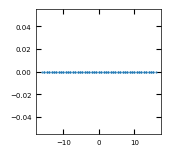

In [18]:
BE_viz.hysteresis_comparison(data = ['LSQF'])

## Neural Network Fits

In [36]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

KeyError: 'Unable to synchronously open object (component not found)'

In [31]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim


data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
# V = np.swapaxes(np.atleast_2d(dataset.get_voltage), 0, 1).astype(np.float64)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            voltage[:,0].squeeze(), # x data
#                             V.squeeze(),
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)

X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 500}


train = True

if train:
    # fits the model
    model.fit(
        X_train,
        1024,
        optimizer=optimizer,
        epochs = 600,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_158961/3599253829.py", line 6, in <module>
    data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
  File "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/dataset.py", line 50, in wrapper
    out = func(*args, **kwargs)
  File "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/dataset.py", line 1874, in get_hysteresis
    if output_shape is not None:
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/h5py/_hl/group.py", line 357, in __ge

In [32]:
import torch
X_train = torch.atleast_3d(torch.tensor(X_train))


train_pred_recon, train_pred_params_scaled, train_pred_params = model.predict(
    X_train,
    1024,
    translate_params=False,
    is_SHO=False
)

NameError: name 'X_train' is not defined

In [ ]:
train_pred_recon.shape
train_pred_params_scaled.shape
train_pred_params.shape

In [ ]:
X_train[1000].shape

In [ ]:
voltage.shape

In [ ]:
i = np.random.randint(0, X_train.shape[0])

import matplotlib.pyplot as plt
plt.plot(voltage, X_train[i])
plt.plot(voltage, np.atleast_2d(train_pred_recon[i]))

### Evaluate the Neural Network Results

In [ ]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

In [ ]:
X_test = torch.atleast_3d(torch.tensor(X_test))

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Test",
)

### Calculate the MSE

In [ ]:
data_ = (torch.atleast_3d(torch.tensor(data.reshape(-1, 96))), X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]

model.print_mse(data_, labels, is_SHO=False)

## Comparison of LSQF and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


In [ ]:
n = 1

data = ("LSQF", "NN")
# names = ["LSQF", "NN"]

BE_viz.hysteresis_comparison(
    data,
    model=model,
    filename="Figure_XX_LSQF_NN_bmw_comparison",
)

### Statistics of the Results for Training, Validation, and Entire Dataset

In [ ]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

BE_viz.violin_plot_comparison_hysteresis(model,
                                         torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
                                         filename="Figure_XX_Violin") 

### Color Maps of Parameters

In [ ]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
data = torch.atleast_3d(torch.tensor(data.reshape(-1, 96)))

pred_recon, pred_params_scaled, pred_params = model.predict(
    data,
    1024,
    translate_params=False,
    is_SHO=False
)

BE_viz.hysteresis_maps(pred_params, filename="Figure_XX_NN_Hysteresis_Maps")